In [28]:
import math
import glob

import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import tensorflow as tf
import multiprocess
tqdm.pandas()

pool = multiprocess.Pool()

from IPython.display import Image, display

ANNOTATIONS_FILE = "annotations.pkl"
IMAGE_PREFIX = "../data/train/images/"
TEST_IMAGES_PATH = "../data/test/images/*"

In [29]:
annotations = pd.read_pickle(ANNOTATIONS_FILE)
annotations['image_path'] = IMAGE_PREFIX + annotations.image
annotations.head(2)

,source,chart-type,plot-bb,text,axes,data-series,image,image_path
0,generated,scatter,"{'height': 231, 'width': 416, 'x0': 57, 'y0': 65}","[{'id': 0, 'polygon': {'x0': 85, 'x1': 478, 'x...","{'x-axis': {'ticks': [{'id': 9, 'tick_pt': {'x...","[{'x': 1949.4200576738224, 'y': 66.68303958393...",e91e28111e86.jpg,../data/train/images/e91e28111e86.jpg
1,generated,vertical_bar,"{'height': 164, 'width': 393, 'x0': 68, 'y0': 37}","[{'id': 0, 'polygon': {'x0': 109, 'x1': 355, '...","{'x-axis': {'ticks': [{'id': 11, 'tick_pt': {'...","[{'x': 'Jordan', 'y': 88.35159235668789}, {'x'...",75c0449f6917.jpg,../data/train/images/75c0449f6917.jpg


In [30]:
IMAGE_SIZE = (128, 128)

def load_squared_gray_pictures(image_path):
    image = skimage.io.imread(image_path)
    gray_image = skimage.color.rgb2gray(image)
    return skimage.transform.resize(gray_image, IMAGE_SIZE)

In [31]:
chart_type_labels = annotations['chart-type'].unique()
id_to_chart_type = dict(enumerate(chart_type_labels))
chart_type_to_id = {v: k for k, v in id_to_chart_type.items()}

In [32]:
annotations_train, annotations_test = train_test_split(annotations, test_size=0.2, stratify=annotations['chart-type'], random_state=123)
annotations_train, annotations_val = train_test_split(annotations_train, test_size=0.2, stratify=annotations_train['chart-type'], random_state=123)

In [33]:
class ChartClassificationGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        annotations,
        batch_size: int = 32,
        shuffle: bool = False,
        random_state: int = 123,
    ) -> None:
        super().__init__()
        self.shuffle = shuffle
        self.images_path = annotations.image_path.values
        self.labels = annotations["chart-type"].map(chart_type_to_id).values
        self.indices = np.arange(len(self.images_path))
        self.batch_size = batch_size
        self.random = np.random.RandomState(random_state)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.images_path) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        pictures = np.stack(
            [self.load_image(image_path) for image_path in self.images_path[indices]]
        )
        return pictures, self.labels[indices]

    def on_epoch_end(self):
        if self.shuffle:
            self.random.shuffle(self.indices)

    @staticmethod
    def load_image(image_path: str):
        image = skimage.io.imread(image_path)
        gray_image = skimage.color.rgb2gray(image)
        return skimage.transform.resize(gray_image, IMAGE_SIZE)


In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

BATCH_SIZE = 32

simple_aug = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    ]
)

In [35]:
def build_chart_type_model(n_classes):
    new_shape = ((IMAGE_SIZE[0] // 4), (IMAGE_SIZE[1] // 4) * 64)
    model = tf.keras.Sequential([
        layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name="image", dtype="float32"),
        layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
        layers.MaxPooling2D((2, 2), name="pool1"),
        layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
        layers.MaxPooling2D((2, 2), name="pool2"),
        layers.Reshape(target_shape=new_shape, name="reshape"),
        layers.Dense(64, activation="linear", name="dense1"),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_classes, activation="softmax", name="output")
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

chart_type_model = build_chart_type_model(len(chart_type_to_id))
chart_type_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 reshape (Reshape)           (None, 32, 2048)          0         
                                                                 
 dense1 (Dense)              (None, 32, 64)            131136    
                                                                 
 dropout_3 (Dropout)         (None, 32, 64)           

In [36]:
history = chart_type_model.fit(
    ChartClassificationGenerator(annotations_train[:2000], shuffle=True),
    validation_data=ChartClassificationGenerator(annotations_val[:100]),
    epochs=10
)

chart_type_model.save("models/charttype_prediction_1.tf")

Epoch 1/10


2023-03-30 20:49:22.852398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 1.0750 - accuracy: 0.5675

2023-03-30 20:50:13.354057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 53s 822ms/step - loss: 1.0750 - accuracy: 0.5675 - val_loss: 0.6154 - val_accuracy: 0.7000
Epoch 2/10
63/63 [==============================] - 31s 498ms/step - loss: 0.5113 - accuracy: 0.7845 - val_loss: 0.3497 - val_accuracy: 0.9100
Epoch 3/10
63/63 [==============================] - 32s 504ms/step - loss: 0.3461 - accuracy: 0.8575 - val_loss: 0.2205 - val_accuracy: 0.9600
Epoch 4/10
63/63 [==============================] - 31s 485ms/step - loss: 0.2545 - accuracy: 0.8985 - val_loss: 0.2563 - val_accuracy: 0.9000
Epoch 5/10
63/63 [==============================] - 30s 480ms/step - loss: 0.1752 - accuracy: 0.9330 - val_loss: 0.1463 - val_accuracy: 0.9300
Epoch 6/10
63/63 [==============================] - 32s 505ms/step - loss: 0.1737 - accuracy: 0.9395 - val_loss: 0.1425 - val_accuracy: 0.9600
Epoch 7/10
63/63 [==============================] - 31s 497ms/step - loss: 0.1123 - accuracy: 0.9600 - val_loss: 0.0894 - val_accuracy: 0.9700
Epoch 8/10

2023-03-30 20:55:00.149509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,32,64]
	 [[{{node inputs}}]]
2023-03-30 20:55:00.157436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,2048]
	 [[{{node inputs}}]]
2023-03-30 20:55:00.166096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,64]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: models/charttype_prediction_1.tf/assets


INFO:tensorflow:Assets written to: models/charttype_prediction_1.tf/assets


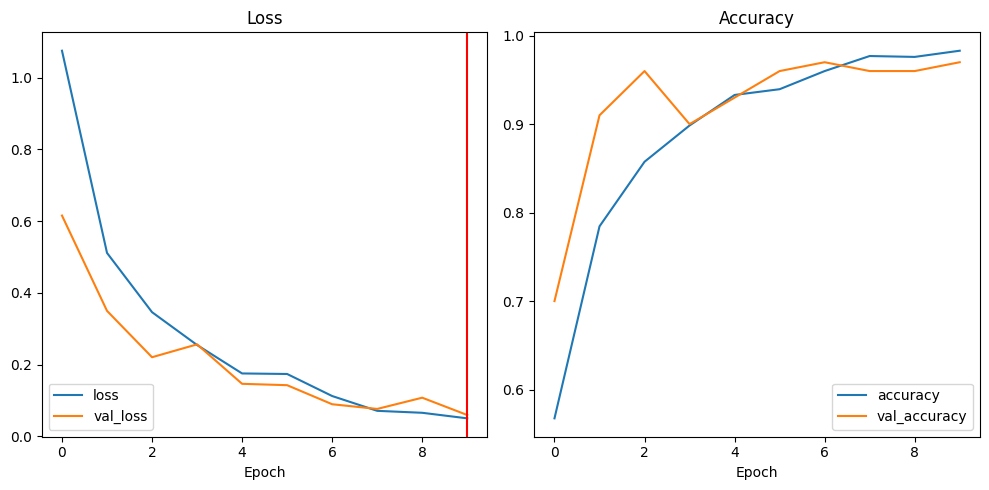

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.axvline(x=np.argmin(history.history['val_loss']), c='r')
plt.xlabel("Epoch")
# plt.yscale("log")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
# plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score

predictions_test = chart_type_model.predict(ChartClassificationGenerator(annotations_test[:1000]))
predictions_test = np.argmax(predictions_test, axis=1)
test_y = annotations_test['chart-type'].map(chart_type_to_id).values[:1000]
print("Accuracy", accuracy_score(test_y, predictions_test))
print(chart_type_labels)
confusion_matrix(test_y, predictions_test)

2023-03-30 20:55:02.526347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 24s 752ms/step
Accuracy 0.957
['scatter' 'vertical_bar' 'dot' 'line' 'horizontal_bar']


array([[183,   0,   0,   5,   0],
       [  3, 306,   2,   7,   0],
       [  0,   0,  88,   3,   0],
       [  5,  17,   0, 380,   0],
       [  0,   0,   0,   1,   0]])

In [52]:
def predict_image_charttype(path: str) -> str:
    probs = chart_type_model.predict(np.array([ChartClassificationGenerator.load_image(test_image)]), verbose=0)
    predicted_class = np.argmax(probs, axis=1)[0]
    return id_to_chart_type[predicted_class]

for test_image in sorted(glob.glob(TEST_IMAGES_PATH)):
    print(test_image, ":", predict_image_charttype(test_image))
    

../data/test/images/000b92c3b098.jpg : line
../data/test/images/007a18eb4e09.jpg : scatter
../data/test/images/00dcf883a459.jpg : scatter
../data/test/images/00f5404753cf.jpg : scatter
../data/test/images/01b45b831589.jpg : vertical_bar
